In [4]:
import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [5]:
train_dir = os.path.join("C:/Users/joshi/Downloads/archive (1)/train")
test_dir = os.path.join("C:/Users/joshi/Downloads/archive (1)", "test")
origin_dir = os.path.join("C:/Users/joshi/Downloads/archive (1)/garbage_classification")
categories = os.listdir(origin_dir)


In [6]:
for category in categories:
    category_src_path = os.path.join(origin_dir, category)
    category_dst_path_train = os.path.join(train_dir, category)
    category_dst_path_test = os.path.join(test_dir, category)
    os.makedirs(category_dst_path_train, exist_ok = True)
    os.makedirs(category_dst_path_test, exist_ok = True)
    
    file_names = os.listdir(category_src_path)
    random.shuffle(file_names)
    length = len(file_names)
    train_file_names = file_names[:int(length*0.8)]
    test_file_names = file_names[int(length*0.8):]
    
    for name in train_file_names:
        src_path = os.path.join(category_src_path, name)
        dst_path = os.path.join(category_dst_path_train, name)
        shutil.copyfile(src = src_path,
                        dst = dst_path)
        
    for name in test_file_names:
        src_path = os.path.join(category_src_path, name)
        dst_path = os.path.join(category_dst_path_test, name)
        shutil.copyfile(src = src_path,
                        dst = dst_path)


In [7]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                             validation_split = 0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_data = train_gen.flow_from_directory("C:/Users/joshi/Downloads/archive (1)/train",
                                            subset = "training", seed = 42, target_size = (299, 299))
val_data = train_gen.flow_from_directory("C:/Users/joshi/Downloads/archive (1)/train",
                                            subset = "validation", seed = 42, target_size = (299, 299))
test_data = test_gen.flow_from_directory("C:/Users/joshi/Downloads/archive (1)/test", seed = 42, target_size = (299, 299))

Found 11918 images belonging to 12 classes.
Found 2974 images belonging to 12 classes.
Found 5589 images belonging to 12 classes.


In [8]:
class_counts = {}

train_path = os.path.join("C:/Users/joshi/Downloads/archive (1)/train")
for cls in os.listdir(train_path):
    class_path = os.path.join(train_path, cls)
    class_counts[cls] = len(os.listdir(class_path))
    
class_counts = dict(sorted(class_counts.items(), key=lambda x:x[1], reverse = True))
class_counts

{'clothes': 5118,
 'shoes': 1889,
 'paper': 1004,
 'biological': 943,
 'battery': 905,
 'cardboard': 850,
 'plastic': 839,
 'white-glass': 746,
 'metal': 740,
 'trash': 670,
 'green-glass': 601,
 'brown-glass': 587}

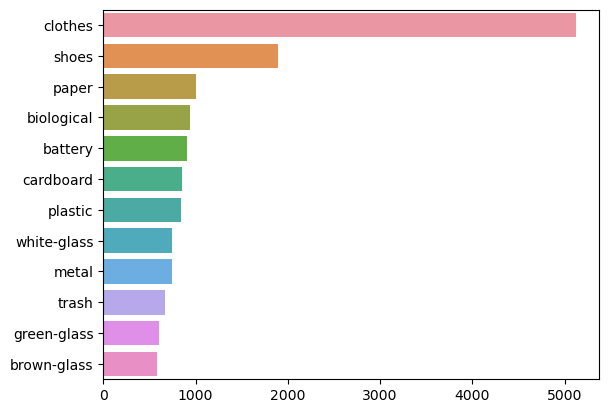

In [9]:
g = sns.barplot(x = list(class_counts.values()), y = list(class_counts.keys()))

In [10]:
class_names = list(train_data.class_indices.keys())
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

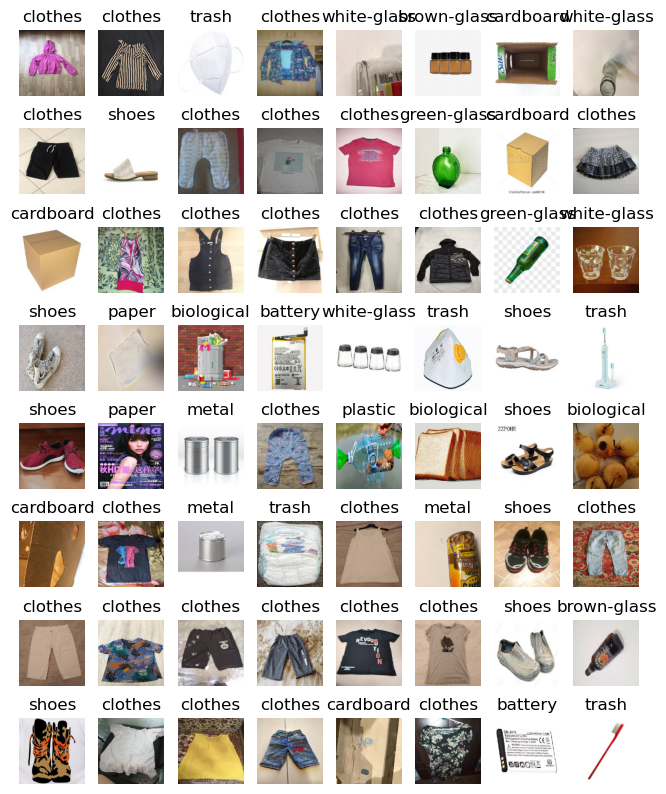

In [11]:
fig, ax = plt.subplots(8, 8, figsize = (8, 10))
for i in range(8*8):
    img = train_data[i][0][0]
    current_axis = ax[i // 8][i % 8]
    class_idx = np.argmax(train_data[i][1][0])
    current_axis.set_title(class_names[class_idx])
    current_axis.imshow(img)
    current_axis.axis("off")

In [12]:
base_model = tf.keras.applications.xception.Xception(include_top = False,
                                                 weights = "imagenet",
                                                 input_shape = (299, 299, 3))
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)
x = data_augmentation(base_model.output)
avg = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(12, activation = "softmax")(avg)
model = keras.Model(inputs = base_model.input, outputs = output)

In [13]:
for layer in base_model.layers:
    layer.trainable = False

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="top_aug_no_sh.h5",
    save_best_only=True,
    monitor="val_loss"),
    
    keras.callbacks.EarlyStopping(patience = 10,
                                  restore_best_weights = True)
]

In [15]:
optimizer = keras.optimizers.SGD(lr = 0.2, momentum = 0.9)
model.compile(loss = "categorical_crossentropy", optimizer = optimizer,
              metrics = "accuracy")
history = model.fit(train_data,
                    epochs = 2,
                    validation_data = val_data,
                    callbacks = callbacks
                   )

Epoch 1/2



373/373 [==============================] - ETA: 0s - loss: 0.5216 - accuracy: 0.8688

C:\Users\joshi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


373/373 [==============================] - 1865s 5s/step - loss: 0.5216 - accuracy: 0.8688 - val_loss: 0.3359 - val_accuracy: 0.9005
Epoch 2/2
373/373 [==============================] - 1730s 5s/step - loss: 0.2484 - accuracy: 0.9353 - val_loss: 0.2785 - val_accuracy: 0.9176


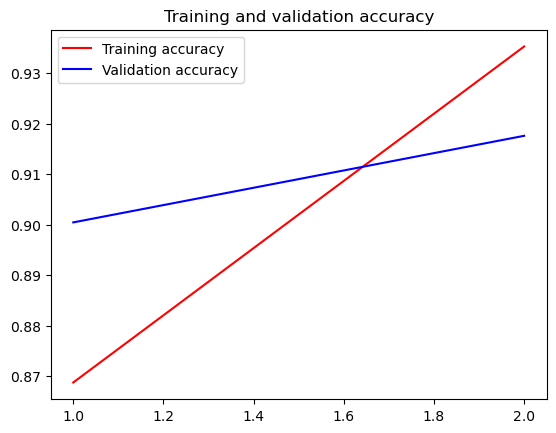

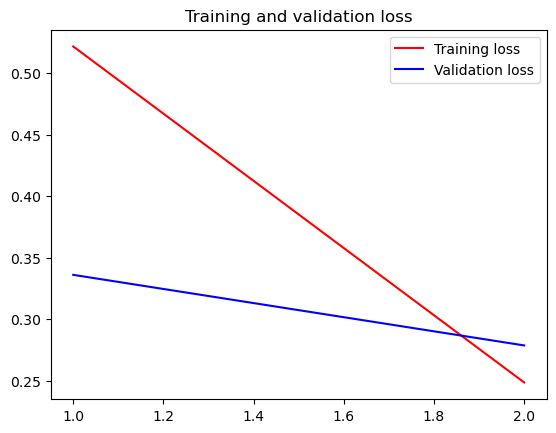

In [16]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "r", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [17]:
for layer in base_model.layers:
    layer.trainable = True

    
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="model_aug_no_sh.h5",
    save_best_only=True,
    monitor="val_loss"),
    
    keras.callbacks.EarlyStopping(patience = 10,
                                  restore_best_weights = True)
]

In [ ]:
optimizer = keras.optimizers.SGD(lr = 0.01, momentum = 0.9)
model.compile(loss = "categorical_crossentropy", optimizer = optimizer,
              metrics = "accuracy")
history = model.fit(train_data,
                    epochs = 2,
                    validation_data = val_data,
                    callbacks = callbacks
                    
                    
                    
                   )

Epoch 1/2
  1/373 [..............................] - ETA: 3:42:56 - loss: 0.2618 - accuracy: 0.9062

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "r", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
def get_prediction(img_path):

    class_names = list(train_data.class_indices.keys())
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis("off")
    img = tf.image.resize(img, (299, 299))
    img *= 1./255
    img = np.expand_dims(img, axis = 0)
    predictions = model.predict(img)
    plt.title(class_names[np.argmax(predictions)])

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf


In [ ]:
# Assuming `model` and `train_data` are already defined
class_names = list(train_data.class_indices.keys())

def get_prediction(img):
    plt.imshow(img)
    plt.axis("off")
    
    img = tf.image.resize(img, (299, 299))
    img *= 1./255
    img = np.expand_dims(img, axis=0)
    
    predictions = model.predict(img)
    plt.title(class_names[np.argmax(predictions)])
    s = class_names[np.argmax(predictions)]
    plt.show()
    return s


In [ ]:
# Open the camera (0 is typically the default camera)
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()

    if not ret:
        print("Failed to capture image from camera.")
        break

    # Convert BGR image to RGB
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the prediction
    s = get_prediction(img_rgb)

    # Break the loop if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break




In [ ]:
#  close the OpenCV window
cap.release()
cv2.destroyAllWindows()